# 05_Lecture_From-scratch_model

Linear Model >> Matrix multiplication >> NN >> DL on Titanic Kaggel database

This Lecture is progressively biult on the following Notebooks:
1) https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch
2) https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework

**Comments:**

Demonstration of how important a feature engineering is: Titanic using Name only [0.81818] (https://www.kaggle.com/code/cdeotte/titanic-using-name-only-0-81818/notebook) and Titanic - Advanced Feature Engineering Tutorial (https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/)

# Import libraries

In [79]:
import pandas as pd
import numpy as np
import torch
from torch import tensor
from fastai.data.transforms import RandomSplitter
import torch.nn.functional as F

In [2]:
# a little bit correct the formats in which tabular data will be printed
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# Step 1. Prepare the dataset
## 1) Download the dataset
The dataset was downloaded on PC from the web https://www.kaggle.com/competitions/titanic/data# and saved to the working directory.

In [3]:
train_df = pd.read_csv('/Users/hela/Code/fast_ai/titanic/train.csv')
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Here's how we get a quick summary of all the non-numeric columns in the dataset:

In [4]:
train_df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## 2) Clean NA
For a plain linear model, we multiply each column by some coefficients. But we can see that our dataset contains missing values. We can't multiply something by a missing value! So let's clean NA cells.

In [5]:
# investigate how many NAs are in the table
train_df.isna()  # all values
train_df.isna().sum()  # summary

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We'll need to replace the missing values with something.  
It doesn't generally matter too much what we choose. We'll use the most common value to replace empty cells. For this, we can use the "mode: function.
(One wrinkle is that it returns more than one row in the case of ties, so we just grab the first row with iloc[0])

After this, we can use "fillna" to replace the missing values with the mode of each column. We'll do it "in place" -- meaning that we'll change the dataframe itself, rather than returning a new one.

In [6]:
# get modes for each column
modes = train_df.mode().iloc[0]
# look at them
print(modes)
# replace NAs
train_df.fillna(modes, inplace=True)
# check that there is no NAs anymore
train_df.isna().sum()

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## 3) Log transformation for some Vs
We can see that Fare contains mainly values of around 0 to 30, but there's a few really big ones. This is very common with fields contain monetary values, and it can cause problems for our model, because once that column is multiplied by a coefficient later, the few rows with really big values will dominate the result.

You can see the issue most clearly visually by looking at a histogram, which shows a long tail to the right (and don't forget: if you're not entirely sure what a histogram is, Google "histogram tutorial" and do a bit of reading before continuing on):

<Axes: >

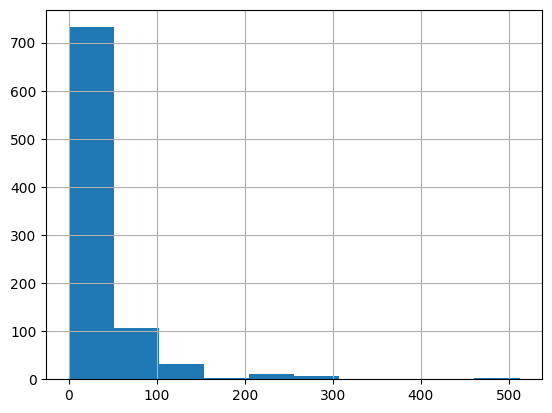

In [7]:
train_df['Fare'].hist()

Let's perform log data transformation.
(however, that there are zeros in the Fare column, and log(0) is infinite -- to fix this, we'll simply add 1 to all values first)

<Axes: >

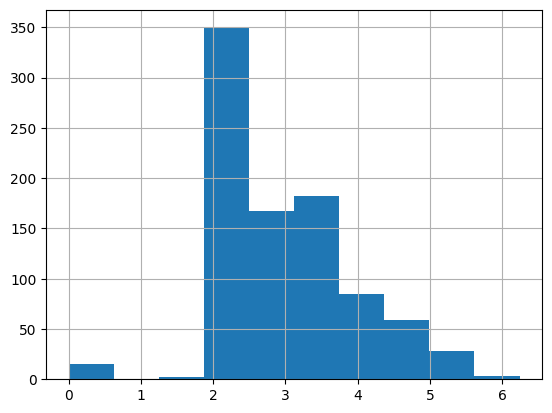

In [8]:
# transform data
train_df['LogFare'] = np.log(train_df['Fare']+1)
# see the result on histogram
train_df['LogFare'].hist()

## 4) Dummy variables
Clearly we can't multiply strings like male or S by coefficients, so we need to replace those with numbers.

We do that by creating new columns containing dummy variables. A dummy variable is a column that contains a 1 where a particular column contains a particular value, or a 0 otherwise. For instance, we could create a dummy variable for Sex='male', which would be a new column containing 1 for rows where Sex is 'male', and 0 for rows where it isn't.

Pandas can create these automatically using get_dummies, which also remove the original columns. We'll create dummy variables for Pclass, even although it's numeric, since the numbers 1, 2, and 3 correspond to first, second, and third class cabins - not to counts or measures that make sense to multiply by. We'll also create dummies for Sex and Embarked since we'll want to use those as predictors in our model.

In [9]:
train_df = pd.get_dummies(train_df, columns=["Sex","Pclass","Embarked"], dtype=int)
train_df

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,B96 B98,2.639057,0,1,0,1,0,0,0,1
887,888,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,3.433987,1,0,1,0,0,0,0,1
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",24.0,1,2,W./C. 6607,23.4500,B96 B98,3.196630,1,0,0,0,1,0,0,1
889,890,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,3.433987,0,1,1,0,0,1,0,0


We can see that new columns have been added to the end -- one for each of the possible values of each of the three columns we requested, and that those three requested columns have been removed.

In [10]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
train_df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


## 5) Data normalizing
Actually, here this step will be performed later, see the "Create predictions" section.

## 6) IVs and DVs
Now we can create our independent (predictors) and dependent (target) variables. They both need to be PyTorch tensors.

In [11]:
# DV:
dv = tensor(train_df.Survived)

In [12]:
# IVS:
iv_columns = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
iv = tensor(train_df[iv_columns].values, dtype=torch.float)
iv

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [13]:
# number of rows and columns we have for ivs:
print(iv.shape)
# the rank of the tensor:
print(len(iv.shape))

torch.Size([891, 12])
2


# Step 2. Linear model
## 1. Setting up
Now we can work on calculating our predictions and our loss. In this section, we're going to manually do a single step of calculating predictions and loss for every row of our data. Our first model will be a simple linear model. 

### 1) Initialize coefficiants (fn)
We'll need a coefficient for each column in train_iv.  
We'll pick random numbers in the range (-0.5,0.5), and set our manual seed so that my explanations in the prose in this notebook will be consistent with what you see when you run it.  
The number of coefficients we need in the number of our IVs, which is 12 in torch.Size([891, 12]).  
Since torch will generate numbers between 0 and 1, we will substruct them by 0.5 so they will be centered.

In [14]:
torch.manual_seed(442)  # for getting results reproducable
n_coeff = iv.shape[1]  # number of coeffs
coeffs = torch.rand(n_coeff)-0.5  # create 12 random numbers and center them
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

Pop it into (not)final function:

In [15]:
def init_coeffs():
    return torch.rand(n_coeff)-0.5
init_coeffs()

tensor([ 0.1722,  0.2324, -0.3575, -0.0010, -0.1833, -0.2411,  0.0489,  0.0866, -0.0534,  0.3132, -0.1487, -0.2551])

### 2) Preds (fn)

1) Create predictions (multiply IVs by coefficients)
   
Our predictions will be calculated by multiplying each row by the coefficients, and adding them up. One interesting point here is that we don't need a separate constant term (also known as a "bias" or "intercept" term), or a column of all 1s to give the same effect has having a constant term. That's because our dummy variables already cover the entire dataset -- e.g. there's a column for "male" and a column for "female", and everyone in the dataset is in exactly one of these; therefore, we don't need a separate intercept term to cover rows that aren't otherwise part of a column.

In [16]:
# element pairwise multiplication, broadcastning (aka looping 12*12 elements mult, 891 times)
iv*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

2) Data normalizing (Back to data preparation step)

We can see we've got a problem here. The sums of each row will be dominated by the first column, which is Age, since that's bigger on average than all the others.

Let's make all the columns contain numbers from 0 to 1, by dividing each column by its max().
(dim=0 means that we want a max for each column, not rows)

That is dividing a matrix by a vector -- what on earth does that mean?!? The trick here is that we're taking advantage of a technique in numpy and PyTorch (and many other languages, going all the way back to APL) called broadcasting. In short, this acts as if there's a separate copy of the vector for every row of the matrix, so it divides each row of the matrix by the vector. In practice, it doesn't actually make any copies, and does the whole thing in a highly optimized way, taking full advantage of modern CPUs (or, indeed, GPUs, if we're using them).

In [17]:
vals,indices = iv.max(dim=0)  # returns 2 things by default: the actual value and a row index. we nee donly vals
iv = iv / vals
iv

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [18]:
# repeat multiplication:
iv*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

3) Create predictions (second attempt)

We can now create predictions from our linear model, by adding up the rows of the product.


In [19]:
preds = (iv*coeffs).sum(axis=1)  # over the columns
preds

tensor([     0.1927,     -0.6239,      0.0979,      0.2056,      0.0968,      0.0066,      0.1306,      0.3476,      0.1613,     -0.6285,
             0.2579,      0.0796,      0.1836,      0.2457,      0.1676,     -0.0595,      0.2014,      0.1783,      0.0589,     -0.6892,
             0.0909,      0.1205,      0.0089,      0.2945,      0.2614,      0.1999,     -0.6378,      0.4071,     -0.0425,      0.1611,
            -0.5679,     -0.5688,     -0.0420,     -0.0576,     -0.5197,      0.2173,     -0.6378,      0.1778,      0.1515,     -0.6284,
             0.0284,      0.1104,     -0.6406,     -0.4960,     -0.0136,      0.1605,      0.0038,     -0.0420,     -0.6399,      0.1345,
             0.3138,      0.1788,     -0.6902,      0.0915,     -0.7009,      0.3176,      0.1514,     -0.6638,      0.3084,      0.3422,
            -0.6262,      0.1563,      0.1831,      0.3664,     -0.4753,     -0.6049,      0.1051,      0.1890,      0.2996,      0.1812,
             0.1392,      0.2618, 

4. Pop it into final function:

In [20]:
def calc_preds(coeffs, iv): 
    return (iv*coeffs).sum(axis=1)

### 3) Loss (fn)

Of course, these predictions aren't going to be any use, since our coefficients are random -- they're just a starting point for our gradient descent process.

To do gradient descent, we need a loss function. Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent) is generally a reasonable approach:

In [21]:
loss = torch.abs(preds-dv).mean()  # mean absolute error cost function
loss

tensor(0.5382)

Pop it into final function:

In [22]:
def calc_loss(coeffs, iv, dv): 
    return torch.abs(calc_preds(coeffs, iv)-dv).mean()

## 2. Gradient Descent
In this section, we're going to do a single "epoch" of gradient descent manually. 

### 1) Init coeff with grads (fn)
The only thing we're going to automate is calculating gradients, because let's face it that's pretty tedious and entirely pointless to do by hand! To get PyTorch to calculate gradients, we'll need to call requires_grad_() on our coeffs 
(_ a the end of requirew_grad is inplace operation, so its gonna change coeffs)

In [23]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

### 2) Update coeffs (fn)
Use backward() to ask PyTorch to calculate gradients now.

Note that each time we call backward, the gradients are actually added to whatever is in the .grad attribute. So if you try running the steps again, you will see that our .grad values are have doubled. That's because it added the gradients a second time. For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero.

In [24]:
loss = calc_loss(coeffs, iv, dv)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [25]:
loss.backward()
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [26]:
loss = calc_loss(coeffs, iv, dv)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

### 3) GD step (fn)
We can now do one gradient descent step, and check that our loss decreases.

First we again calculate initial loss, then we should see that each time we run the code, our loss (the result of the cell) should become less and less:

In [27]:
loss = calc_loss(coeffs, iv, dv)
loss.backward()

with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)  # substract from the coeffs their gradients * learning rate
    coeffs.grad.zero_()
    print(calc_loss(coeffs, iv, dv))

tensor(0.4945)


## 3. Training
### 1) Validation set
Use RandomSplitter to get indices that will split our data into training and validation sets

In [28]:
train_split, valid_split = RandomSplitter(seed=42)(train_df)
valid_split

(#178) [np.int64(303),np.int64(778),np.int64(531),np.int64(385),np.int64(134),np.int64(476),np.int64(691),np.int64(443),np.int64(386),np.int64(128),np.int64(579),np.int64(65),np.int64(869),np.int64(359),np.int64(202),np.int64(187),np.int64(456),np.int64(880),np.int64(705),np.int64(797)...]

Apply those indicies to our independent and dependent variables

In [29]:
train_iv, valid_iv = iv[train_split], iv[valid_split]
train_dv, valid_dv = dv[train_split], dv[valid_split]
len(train_iv),len(valid_iv)

(713, 178)

### 2) Define functions from above (fns)
   
Create functions for the three things we did manually above

In [30]:
# Initialize coeffs
def init_coeffs():
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [31]:
# GD step
def GD_step(coeffs, lr):
    loss = calc_loss(coeffs, train_iv, train_dv)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [32]:
# updating coeffs
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

### 3) Combine fns into train_model fn (fn)
Put them all together to train the model fn

In [33]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        GD_step(coeffs, lr=lr)
    return coeffs

### 4) Train the model
Try our fn. Our loss will print at the end of every step, so we hope we'll see it going down.

In [34]:
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

In [35]:
# look at the coeffs for each column:
def show_coeffs(): 
    return dict(zip(iv_columns, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

## 4. Results & accuracy (fn)
The Kaggle competition is not, however, scored by absolute error (which is our loss function). It's scored by accuracy -- the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions on updated coeffs)

In [36]:
preds = calc_preds(coeffs,valid_iv)

We'll assume that any passenger with a score of over 0.5 is predicted to survive. So that means we're correct for each row where preds>0.5 is the same as the dependent variable:

In [37]:
results = valid_dv.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

Average accuracy:

In [38]:
results.float().mean()

tensor(0.7865)

Pop it into final function:

In [39]:
def acc(coeffs):
    return (valid_dv.bool()==(calc_preds(coeffs, valid_iv)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

## 5. Sigmoid (fn)
Looking at our predictions, there's one obvious problem -- some of our predictions of the probability of survival are >1, and some are <0. To fix this, we should pass every prediction through the sigmoid function, which has a minimum at zero and maximum at one. PyTorch already defines that function for us, so we can modify calc_preds to use it.

In [40]:
def calc_preds(coeffs, iv): 
    return torch.sigmoid((iv*coeffs).sum(axis=1))

Train new model with sogmoid wil get us better result:

In [41]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [42]:
acc(coeffs)

tensor(0.8258)

In [43]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

## 6. Final submission
### 1) Prepare the test dataset
First, prepare the test set

In [44]:
# dowmload test dataset
test_df = pd.read_csv('/Users/hela/Code/fast_ai/titanic/test.csv')
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [45]:
# clean NA (get modes for each column and replace NAs)
modes_test = test_df.mode().iloc[0]
test_df.fillna(modes_test, inplace=True)
train_df.isna().sum() 

PassengerId    0
Survived       0
Name           0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
LogFare        0
Sex_female     0
Sex_male       0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

<Axes: >

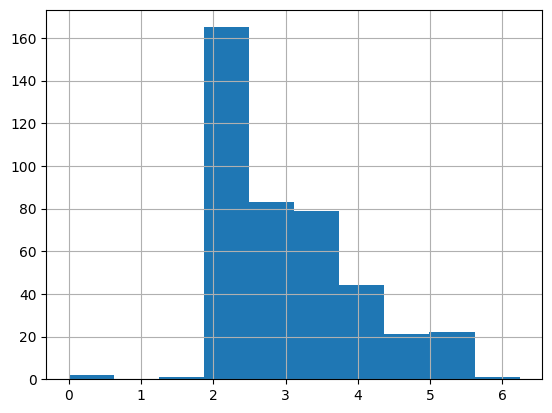

In [46]:
# lag transformation for some Vs
test_df['LogFare'] = np.log(test_df['Fare']+1)
test_df['LogFare'].hist()

In [47]:
# dummy variables
test_df = pd.get_dummies(test_df, columns=["Sex","Pclass","Embarked"], dtype=int)
test_df

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,B57 B59 B63 B66,2.178064,0,1,0,0,1,0,1,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,B57 B59 B63 B66,2.079442,1,0,0,0,1,0,0,1
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,B57 B59 B63 B66,2.369075,0,1,0,1,0,0,1,0
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,B57 B59 B63 B66,2.268252,0,1,0,0,1,0,0,1
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,B57 B59 B63 B66,2.586824,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,"Spector, Mr. Woolf",21.0,0,0,A.5. 3236,8.0500,B57 B59 B63 B66,2.202765,0,1,0,0,1,0,0,1
414,1306,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,4.699571,1,0,1,0,0,1,0,0
415,1307,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,B57 B59 B63 B66,2.110213,0,1,0,0,1,0,0,1
416,1308,"Ware, Mr. Frederick",21.0,0,0,359309,8.0500,B57 B59 B63 B66,2.202765,0,1,0,0,1,0,0,1


In [48]:
# IVs:
test_iv = tensor(test_df[iv_columns].values, dtype=torch.float)  # iv_columns was created earlier
print(test_iv.shape)
test_iv

torch.Size([418, 12])


tensor([[34.5000,  0.0000,  0.0000,  2.1781,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [47.0000,  1.0000,  0.0000,  2.0794,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [62.0000,  0.0000,  0.0000,  2.3691,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [27.0000,  0.0000,  0.0000,  2.2683,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [22.0000,  1.0000,  1.0000,  2.5868,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [14.0000,  0.0000,  0.0000,  2.3248,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [30.0000,  0.0000,  0.0000,  2.1552,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        ...,
        [37.0000,  1.0000,  0.0000,  4.5109,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [28.0000,  0.0000,  0.0000,  2.1719

In [49]:
# normalizing
vals_test,indices_test = test_iv.max(dim=0)  # returns 2 things by default: the actual value and a row index. we nee donly vals
test_iv = test_iv / vals_test
test_iv

tensor([[0.4539, 0.0000, 0.0000, 0.3490, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6184, 0.1250, 0.0000, 0.3332, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.8158, 0.0000, 0.0000, 0.3796, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.3553, 0.0000, 0.0000, 0.3634, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.2895, 0.1250, 0.1111, 0.4145, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.1842, 0.0000, 0.0000, 0.3725, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3947, 0.0000, 0.0000, 0.3453, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        ...,
        [0.4868, 0.1250, 0.0000, 0.7228, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.3684, 0.0000, 0.0000, 0.3480, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.2763, 0.0000, 0.0000, 

### 2) Predictions
Calculate predictions of which passengers survived in the test set

In [50]:
test_preds = ((calc_preds(coeffs,test_iv))>0.5).int()
test_preds
# create a column in our test_data
test_df["Survived"] = test_preds
test_df

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Survived
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,B57 B59 B63 B66,2.178064,0,1,0,0,1,0,1,0,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,B57 B59 B63 B66,2.079442,1,0,0,0,1,0,0,1,0
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,B57 B59 B63 B66,2.369075,0,1,0,1,0,0,1,0,0
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,B57 B59 B63 B66,2.268252,0,1,0,0,1,0,0,1,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,B57 B59 B63 B66,2.586824,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,"Spector, Mr. Woolf",21.0,0,0,A.5. 3236,8.0500,B57 B59 B63 B66,2.202765,0,1,0,0,1,0,0,1,0
414,1306,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,4.699571,1,0,1,0,0,1,0,0,1
415,1307,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,B57 B59 B63 B66,2.110213,0,1,0,0,1,0,0,1,0
416,1308,"Ware, Mr. Frederick",21.0,0,0,359309,8.0500,B57 B59 B63 B66,2.202765,0,1,0,0,1,0,0,1,0


### 3) Final submission
The sample submission on the Kaggle competition site shows that we're expected to upload a CSV with just PassengerId and Survived, so let's create that and save it:

In [51]:
# create a submission file
subm_df = test_df[["PassengerId","Survived"]]
subm_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [52]:
# save the submission file
subm_df.to_csv('subm.csv', index=False)
!head subm.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


# Step 3. Matrix multiplication
## 1) Calc preds (matrix mult) (fn)
Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the @ operator to indicate matrix products, and is supported by PyTorch tensors. Therefore, we can replicate the above calculate more simply like so. It also turns out that this is much faster, because matrix products in PyTorch are very highly optimised.

In [53]:
# old:
(valid_iv*coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1066,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

In [54]:
# new:
valid_iv@coeffs

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1066,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

Let's use this to replace how calc_preds works:

In [55]:
def calc_preds(coeffs, iv): 
    return torch.sigmoid(iv@coeffs)

## 2) Column vector for coeffs and dv (fn)
In order to do matrix-matrix products (which we'll need in the next section), we need to:
1) turn coeffs into a column vector (i.e. a matrix with a single column)  
We can do it by passing a second argument 1 to torch.rand(), indicating that we want our coefficients to have one column

In [56]:
def init_coeffs():
    return (torch.rand(n_coeff, 1)*0.1).requires_grad_()
init_coeffs()

tensor([[0.0672],
        [0.0732],
        [0.0142],
        [0.0499],
        [0.0317],
        [0.0259],
        [0.0549],
        [0.0587],
        [0.0447],
        [0.0813],
        [0.0351],
        [0.0245]], requires_grad=True)

2) turn our dependent variable into a column vector  
We can do it by indexing the column dimension with the special value None, which tells PyTorch to add a new dimension in this position:

In [57]:
train_dv = train_dv[:,None]
valid_dv = valid_dv[:,None]
valid_dv

tensor([[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

## 3) Training and results
We can now train our model as before and confirm we get identical outputs and accuracy.

In [58]:
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [60]:
acc(coeffs)

tensor(0.8258)

# Step 4. NN
## 1) init coeffs (fn): hidden and output layers
We've now got what we need to implement our neural network.

First, we'll need to create coefficients for each of our layers. 
1) Our first set of coefficients will take our n_coeff inputs, and create n_hidden outputs. We can choose whatever n_hidden we like -- a higher number gives our network more flexibility, but makes it slower and harder to train. So we need a matrix of size n_coeff by n_hidden. We'll divide these coefficients by n_hidden so that when we sum them up in the next layer we'll end up with similar magnitude numbers to what we started with.
2) Then our second layer will need to take the n_hidden inputs and create a single output, so that means we need a n_hidden by 1 matrix there. The second layer will also need a constant term added.

In [78]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()
init_coeffs()
# layer1.shape

(tensor([[     0.0140,      0.0202,      0.0145,     -0.0168,      0.0015,      0.0191,      0.0246,     -0.0095,     -0.0009,     -0.0243,
               0.0216,     -0.0142,     -0.0176,      0.0109,      0.0057,      0.0020,     -0.0090,     -0.0124,      0.0143,      0.0183],
         [     0.0156,      0.0122,     -0.0041,     -0.0202,     -0.0243,      0.0107,     -0.0205,     -0.0034,     -0.0215,     -0.0238,
               0.0084,     -0.0194,      0.0189,     -0.0154,      0.0183,      0.0215,     -0.0031,      0.0148,      0.0061,      0.0001],
         [    -0.0097,      0.0248,      0.0184,      0.0148,      0.0188,     -0.0216,      0.0049,      0.0056,     -0.0200,     -0.0110,
              -0.0096,     -0.0199,     -0.0157,     -0.0205,     -0.0145,      0.0129,     -0.0126,     -0.0016,      0.0092,      0.0158],
         [     0.0210,      0.0038,      0.0077,     -0.0035,      0.0072,     -0.0171,      0.0119,      0.0200,     -0.0154,     -0.0131,
               0.

## 2) Calc preds (fn): matrix mult
Now we have our coefficients, we can create our neural net. The key steps are the two matrix products, iv@l1 and a@l2 (where a is the output of the first layer). The first layer output is passed to F.relu (that's our non-linearity), and the second is passed to torch.sigmoid as before.

In [81]:
def calc_preds(coeffs, iv): 
    l1, l2, const = coeffs
    a = F.relu(iv@l1)
    a = torch.sigmoid(a@l2 + const)
    return a

## 3) Update coeff (fn): 2 layers
Finally, now that we have more than one set of coefficients, we need to add a loop to update each one

In [82]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

## 4) Train NN
It's looking good -- our loss is lower than before. Let's see if that translates to a better result on the validation set. In this case our neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing we'd expect to see neural networks excel at. Furthermore, our validation set is too small to reliably see much accuracy difference. But the key thing is that we now know exactly what a real neural net looks like!

In [84]:
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [85]:
acc(coeffs)

tensor(0.8258)

# Step 5. Deep learning
## 1) Init coeffs (fn)
NN in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. But we can use the exact same technique to make our NN deep, by adding more matrix multiplications.
First, we'll need to create additional coefficients for each layer.

In [86]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

## 2) Calc preds (fn)
Our deep learning calc_preds looks much the same as before, but now we loop through each layer, instead of listing them separately:

In [87]:
def calc_preds(coeffs, iv):
    layers, consts = coeffs
    n = len(layers)
    a = iv
    for i,l in enumerate(layers):
        a = a@l + consts[i]
        if i!=n-1: a = F.relu(a)
    return torch.sigmoid(a)

## 3) Update coeffs (fn)
We also need a minor update to update_coeffs since we've got layers and consts separated now

In [88]:
def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for layer in layers + consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

## 4) Train NN

In [89]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [90]:
acc(coeffs)

tensor(0.8258)

# Step 6. Fastai framework
Now is a good time to look at how to do the same thing using a library, instead of doing it from scratch. We'll use fastai and PyTorch.

In [101]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## 1) Data preparation
linkcode
When you do everything from scratch, every bit of feature engineering requires a whole lot of work, since you have to think about things like dummy variables, normalization, missing values, and so on. But with fastai that's all done for you. So let's go wild and create lots of new features! We'll use a bunch of the most interesting ones from this fantastic "Titanic - Advanced Feature Engineering Tutorial" (https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/)

In [102]:
train_df = pd.read_csv('/Users/hela/Code/fast_ai/titanic/train.csv')

def add_features(train_df):
    train_df['LogFare'] = np.log1p(train_df['Fare'])
    train_df['Deck'] = train_df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    train_df['Family'] = train_df.SibSp+train_df.Parch
    train_df['Alone'] = train_df.Family==0
    train_df['TicketFreq'] = train_df.groupby('Ticket')['Ticket'].transform('count')
    train_df['Title'] = train_df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    train_df['Title'] = train_df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))
add_features(train_df)

Use RandomSplitter to separate out the training and validation sets

In [103]:
splits = RandomSplitter(seed=42)(train_df)

Now the entire process of getting the data ready for training requires just this one cell!

In [104]:
dls = TabularPandas(
    train_df, splits=splits,  #  indices of training and validation sets
    procs = [Categorify, FillMissing, Normalize],  # strings into categ, fill NAs in num columns with Median, normalise num columns
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],  # categorical IVs
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],  # continous IVs
    y_names="Survived", y_block = CategoryBlock(),  # DV; it is categ (so build a classification model, not a regression model)
).dataloaders(path=".")  # save in the same file

/Users/hela/Code/fast_ai/.venv/lib/python3.13/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


## 2) Train the model
The data and model together make up a Learner. To create one, we say what the data is (dls), and the size of each hidden layer ([10,10]), along with any metrics we want to print along the way.  
You'll notice we didn't have to do any messing around to try to find a set of random coefficients that will train correctly -- that's all handled automatically.

In [105]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

One handy feature that fastai can also tell us what learning rate to use. The two colored points are both reasonable choices for a learning rate. I'll pick somewhere between the two (0.03) because it usually gives the best results. train for a few epochs.

SuggestedLRs(slide=0.03981071710586548, valley=0.015848932787775993)

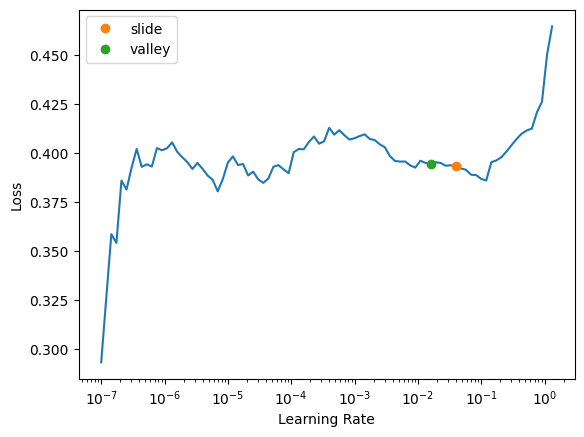

In [107]:
learn.lr_find(suggest_funcs=(slide, valley))

Train the model.
We've got a similar accuracy to our previous "from scratch" model -- which isn't too surprising, since as we discussed, this dataset is too small and simple to really see much difference. A simple linear model already does a pretty good job. But that's OK -- the goal here is to show you how to get started with deep learning and understand how it really works, and the best way to do that is on small and easy to understand datasets.

In [109]:
learn.fit(16, lr=0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.404043,0.424650,0.825843,00:00
1,0.396436,0.415919,0.808989,00:00
2,0.380295,0.417379,0.814607,00:00
3,0.384151,0.427768,0.797753,00:00
4,0.386731,0.414579,0.814607,00:00
5,0.388829,0.408999,0.808989,00:00
6,0.379542,0.436101,0.808989,00:00
7,0.377454,0.438198,0.803371,00:00
8,0.390365,0.420966,0.803371,00:00
9,0.390907,0.415635,0.808989,00:00


## 3) Final submission
One important feature of fastai is that all the information needed to apply the data transformations and the model to a new dataset are stored in the learner. You can call export to save it to a file to use it later in production, or you can use the trained model right away to get predictions on a test set.

To submit to Kaggle, we'll need to read in the test set, and do the same feature engineering we did for the training set

In [111]:
test_df = pd.read_csv('/Users/hela/Code/fast_ai/titanic/test.csv')
test_df['Fare'] = test_df.Fare.fillna(0)
add_features(test_df)

But we don't need to manually specify any of the processing steps necessary to get the data ready for modeling, since that's all saved in the learner. To specify we want to apply the same steps to a new dataset, use the test_dl() method

In [112]:
test_dl = learn.dls.test_dl(test_df)

/Users/hela/Code/fast_ai/.venv/lib/python3.13/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


Now we can use get_preds to get the predictions for the test set

In [115]:
preds,_ = learn.get_preds(dl=test_dl)
preds,_

(tensor([[    0.8713,     0.1287],
         [    0.6754,     0.3246],
         [    0.9069,     0.0931],
         [    0.9020,     0.0980],
         [    0.1747,     0.8253],
         [    0.8813,     0.1187],
         [    0.5895,     0.4105],
         [    0.9067,     0.0933],
         [    0.3697,     0.6303],
         [    0.9164,     0.0836],
         [    0.9081,     0.0919],
         [    0.9186,     0.0814],
         [    0.0378,     0.9622],
         [    0.9146,     0.0854],
         [    0.0208,     0.9792],
         [    0.0162,     0.9838],
         [    0.8613,     0.1387],
         [    0.8310,     0.1690],
         [    0.6351,     0.3649],
         [    0.6239,     0.3761],
         [    0.8632,     0.1368],
         [    0.0261,     0.9739],
         [    0.0560,     0.9440],
         [    0.7799,     0.2201],
         [    0.1971,     0.8029],
         [    0.9099,     0.0901],
         [    0.0051,     0.9949],
         [    0.8345,     0.1655],
         [    0.8569

Finally, let's create a submission CSV just like we did in the previous notebook and check that it looks reasonable

In [116]:
test_df['Survived'] = (preds[:,1]>0.5).int()
subm_df = test_df[['PassengerId','Survived']]
subm_df.to_csv('subm.csv', index=False)

In [117]:
!head subm.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1


# Step 7. Ensembling
Since it's so easy to create a model now, it's easier to play with more advanced modeling approaches. For instance, we can create five separate models, each trained from different random starting points, and average them. This is the simplest approach of ensembling models, which combines multiple models to generate predictions that are better than any of the single models in the ensemble.

To create our ensemble, first we copy the three steps we used above to create and train a model, and apply it to the test set

In [118]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=test_dl)[0]

Run this five times, and collect the results into a list

In [119]:
learns = [ensemble() for _ in range(5)]

Stack this predictions together and take their average predictions

In [121]:
ens_preds = torch.stack(learns).mean(0)
ens_preds

tensor([[0.8905, 0.1095],
        [0.5057, 0.4943],
        [0.9212, 0.0788],
        [0.9019, 0.0981],
        [0.2821, 0.7179],
        [0.8875, 0.1125],
        [0.3428, 0.6572],
        [0.9130, 0.0870],
        [0.1421, 0.8579],
        [0.9123, 0.0877],
        [0.9201, 0.0799],
        [0.8722, 0.1278],
        [0.0478, 0.9522],
        [0.9384, 0.0616],
        [0.0412, 0.9588],
        [0.0349, 0.9651],
        [0.8762, 0.1238],
        [0.7699, 0.2301],
        [0.5099, 0.4901],
        [0.2861, 0.7139],
        [0.7800, 0.2200],
        [0.2467, 0.7533],
        [0.0572, 0.9428],
        [0.7021, 0.2979],
        [0.2028, 0.7972],
        [0.9423, 0.0577],
        [0.0397, 0.9603],
        [0.7744, 0.2256],
        [0.6866, 0.3134],
        [0.8847, 0.1153],
        [0.9358, 0.0642],
        [0.9176, 0.0824],
        [0.4229, 0.5771],
        [0.3718, 0.6282],
        [0.5131, 0.4869],
        [0.7650, 0.2350],
        [0.4105, 0.5895],
        [0.4211, 0.5789],
        [0.8

Use the same code as before to generate a submission file, which we can submit to Kaggle after the notebook is saved and run

In [122]:
test_df['Survived'] = (ens_preds[:,1]>0.5).int()
subm_df = test_df[['PassengerId','Survived']]
subm_df.to_csv('ens_subm.csv', index=False)
!head ens_subm.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
